## Logic Based FizzBuzz Function [Software 1.0]

In [49]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from itertools import islice
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils


## Create Training and Testing Datasets in CSV Format

In [50]:
TrainingTarget = []
TrainingData = []
ValDataAct = []
ValData = []
TestDataAct = []
TestData = []

## Processing Input and Label Data

In [51]:
def CreateHumanSubtract(fdf, x1, x2, y1, y2):
    temp1 = fdf.iloc[:,x1:x2]
    temp2 = fdf.iloc[:,y1:y2]
    sub_df = (temp1 - temp2.values).abs()
    #sub_df = (concat_df[['f1_x','f2_x','f3_x','f4_x','f5_x','f6_x','f7_x','f8_x','f9_x']] - concat_df[['f1_y','f2_y','f3_y','f4_y','f5_y','f6_y','f7_y','f8_y','f9_y']].values).abs()
    return sub_df

def MergeHumanDataset(FeatureData, SamePairs):
    df = pd.merge(SamePairs, FeatureData,  left_on= ['img_id_A'], right_on= ['img_id'], how='left')
    f_df = pd.merge(df, FeatureData, left_on= ['img_id_B'], right_on= ['img_id'], how='left')
    return f_df
#store the 80% of the training target data which is 55699
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80): 
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#store the 80% of the training  data which is 55699
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData)*0.01*TrainingPercent)) # this is computing the column lenth 0 to 55699
    d2 = rawData[0:T_len,:]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#store the 10% of the validation data and testing data which is 6962 which is 41 * 6962
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount+1:V_End,:]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#store the 10% of the validation target and testing target which is 6962 which is 41 * 6962
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(Va
    return t

def ProcessDataset(H_target_df, H_concat_df, TrainingPercent, TestPercent):
    global TrainingTarget
    global TrainingData
    global ValDataAct
    global ValData
    global TestDataAct
    global TestData
    a = np.array(H_concat_df.values)
    RawData = a[:, ~(a == a[0,:]).all(0)]
    TrainingTarget = np.array(GenerateTrainingTarget(H_target_df.values,TrainingPercent))
    TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
    print('----------TRAIND--------------')
    print(TrainingTarget.shape)
    print(TrainingData.shape)
    TestDataAct = np.array(GenerateValTargetVector(H_target_df.values,TestPercent, (len(TrainingTarget))))
    TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)))
    print('----------TD-------------')
    print(TestDataAct.shape)
    print(TestData.shape)


In [52]:
def PreProcessData(filename,f2, f3, x1, x2, y1, y2, iter, trp, tp):
    FeatureData = pd.read_csv(filename) #Extract the da
    SamePairs   = pd.read_csv(f2)
    DiffnPairs   = pd.read_csv(f3)
    Merge_S_df = MergeHumanDataset(FeatureData, SamePairs)
#     print(Merge_S_df.shape)
    Merge_D_df = MergeHumanDataset(FeatureData, DiffnPairs)
#     print(Merge_D_df.shape)
    Merge_D = Merge_D_df.sample(n=Merge_S_df.shape[0])
#     print(Merge_D.shape)
    temp = pd.concat([Merge_S_df, Merge_D])
    temp = temp.sample(frac=1)
#     print(temp)
#     print(temp.shape)
    H_concat_df = temp.iloc[:, np.r_[x1:x2, y1:y2]]
    H_subtract_df = CreateHumanSubtract(temp, x1, x2, y1, y2)
    H_target_df = temp['target']
#     print("H_concat")
#     print(H_concat_df)
#     print(H_concat_df.columns.values)
#     print("H_Sub")
#     print(H_subtract_df)
#     print(H_subtract_df.columns.values)
#     print("H_Target")
#     print(H_target_df)
    print("-------------------------------------------------------------")
    print("                 %s RESULTS" % filename.split(".")[0])
    print("-------------------------------------------------------------")
    print("\n------------------------ CONCAT RESULTS--------------------\n")
    ProcessDataset(H_target_df, H_concat_df, trp, tp)
    history = TrainModel(iter)
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))
    print("\n------------------------ SUBTRACT RESULTS--------------------\n")
    ProcessDataset(H_target_df, H_subtract_df, trp, tp)
    history = TrainModel(iter)
    df = pd.DataFrame(history.history)
    df.plot(subplots=True, grid=True, figsize=(10,15))

## Model Definition

In [53]:
def get_model():
    input_size = TrainingData.shape[1]
    drop_out = 0.3
    first_dense_layer_nodes  = 200
    final_dense_layer_nodes = 2
    second_dense_layer_nodes  = 100
    # Why do we need a model?
    # Why use Dense layer and then activation?
    # Why use sequential model with layers?
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
    # Why dropout?
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('relu'))
    
    model.add(Dropout(drop_out))
    
    model.add(Dense(final_dense_layer_nodes))
    model.add(Activation('softmax'))
    # Why Softmax?
    
    model.summary()
    
    # Why use categorical_crossentropy?
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# <font color = blue>Run Model</font>

In [54]:
def TrainModel(iter):
    model = get_model()
    validation_data_split = 0.2
    num_epochs = iter
    model_batch_size = 211
    tb_batch_size = 32
    early_patience = 100

    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')


    # Process Dataset
    processedData= TrainingData
    print(processedData.shape)
    processedLabel = np_utils.to_categorical(TrainingTarget,2)
    print(processedLabel.shape)

    history = model.fit(processedData
                        , processedLabel
                        , validation_split=validation_data_split
                        , epochs=num_epochs
                        , batch_size=model_batch_size
                        , callbacks = [tensorboard_cb,earlystopping_cb]
                       )
    PrintAccuracy(model)
    return history

# <font color = blue>Testing Accuracy [Software 2.0]</font>

In [55]:
def PrintAccuracy(model):
    wrong   = 0
    right   = 0

    processedTestData  = TestData
    processedTestLabel = np_utils.to_categorical(TestDataAct, 2)

    for i,j in zip(processedTestData,processedTestLabel):
        y = model.predict(np.array(i).reshape(-1,i.shape[0]))

        if j.argmax() == y.argmax():
            right = right + 1
        else:
            wrong = wrong + 1

    print("Errors: " + str(wrong), " Correct :" + str(right))
    print("Testing Accuracy: " + str(right/(right+wrong)*100))

In [56]:
def nn_main():
    PreProcessData("HumanObserved-Features-Data.csv", "same_pairs.csv","diffn_pairs.csv", 5, 14, 16, 25, 100, 80, 20)
    PreProcessData("GSC-Features.csv", "G_same_pairs.csv","G_diffn_pairs.csv", 4, 516, 517, 1029, 50, 40, 10)

-------------------------------------------------------------
                 HumanObserved-Features-Data RESULTS
-------------------------------------------------------------

------------------------ CONCAT RESULTS--------------------

----------TRAIND--------------
(1266,)
(1266, 18)
----------TD-------------
(315,)
(315, 18)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 200)               3800      
_________________________________________________________________
activation_40 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               20100     
_________________________________________________________________
activati

Epoch 48/100
1012/1012 [==============================] - 0s 47us/step - loss: 0.6186 - acc: 0.6630 - val_loss: 0.7559 - val_acc: 0.4803
Epoch 49/100
1012/1012 [==============================] - 0s 65us/step - loss: 0.6171 - acc: 0.6571 - val_loss: 0.7666 - val_acc: 0.4764
Epoch 50/100
1012/1012 [==============================] - 0s 58us/step - loss: 0.6054 - acc: 0.6591 - val_loss: 0.7499 - val_acc: 0.4961
Epoch 51/100
1012/1012 [==============================] - 0s 53us/step - loss: 0.6081 - acc: 0.6729 - val_loss: 0.7476 - val_acc: 0.5039
Epoch 52/100
1012/1012 [==============================] - 0s 59us/step - loss: 0.6113 - acc: 0.6887 - val_loss: 0.7491 - val_acc: 0.5079
Epoch 53/100
1012/1012 [==============================] - 0s 59us/step - loss: 0.6097 - acc: 0.6700 - val_loss: 0.7508 - val_acc: 0.5236
Epoch 54/100
1012/1012 [==============================] - 0s 63us/step - loss: 0.6002 - acc: 0.6611 - val_loss: 0.7479 - val_acc: 0.5197
Epoch 55/100
1012/1012 [=================

(1266, 9)
(1266, 2)
Train on 1012 samples, validate on 254 samples
Epoch 1/100
1012/1012 [==============================] - 0s 456us/step - loss: 0.7210 - acc: 0.5010 - val_loss: 0.6894 - val_acc: 0.5433
Epoch 2/100
1012/1012 [==============================] - 0s 43us/step - loss: 0.7014 - acc: 0.5296 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/100
1012/1012 [==============================] - 0s 53us/step - loss: 0.7018 - acc: 0.5089 - val_loss: 0.7015 - val_acc: 0.4803
Epoch 4/100
1012/1012 [==============================] - 0s 52us/step - loss: 0.6947 - acc: 0.5277 - val_loss: 0.6982 - val_acc: 0.4921
Epoch 5/100
1012/1012 [==============================] - 0s 43us/step - loss: 0.6958 - acc: 0.5257 - val_loss: 0.6959 - val_acc: 0.4921
Epoch 6/100
1012/1012 [==============================] - 0s 44us/step - loss: 0.6876 - acc: 0.5336 - val_loss: 0.6929 - val_acc: 0.5512
Epoch 7/100
1012/1012 [==============================] - 0s 36us/step - loss: 0.6854 - acc: 0.5583 - val_loss: 0.711

1012/1012 [==============================] - 0s 43us/step - loss: 0.6465 - acc: 0.6196 - val_loss: 0.7483 - val_acc: 0.4921
Epoch 61/100
1012/1012 [==============================] - 0s 45us/step - loss: 0.6364 - acc: 0.6255 - val_loss: 0.7375 - val_acc: 0.4843
Epoch 62/100
1012/1012 [==============================] - 0s 47us/step - loss: 0.6451 - acc: 0.6344 - val_loss: 0.7371 - val_acc: 0.4921
Epoch 63/100
1012/1012 [==============================] - 0s 56us/step - loss: 0.6381 - acc: 0.6206 - val_loss: 0.7412 - val_acc: 0.4961
Epoch 64/100
1012/1012 [==============================] - 0s 57us/step - loss: 0.6358 - acc: 0.6383 - val_loss: 0.7384 - val_acc: 0.4961
Epoch 65/100
1012/1012 [==============================] - 0s 47us/step - loss: 0.6398 - acc: 0.6294 - val_loss: 0.7427 - val_acc: 0.4803
Epoch 66/100
1012/1012 [==============================] - 0s 38us/step - loss: 0.6296 - acc: 0.6571 - val_loss: 0.7439 - val_acc: 0.5039
Epoch 67/100
1012/1012 [==============================

MemoryError: 

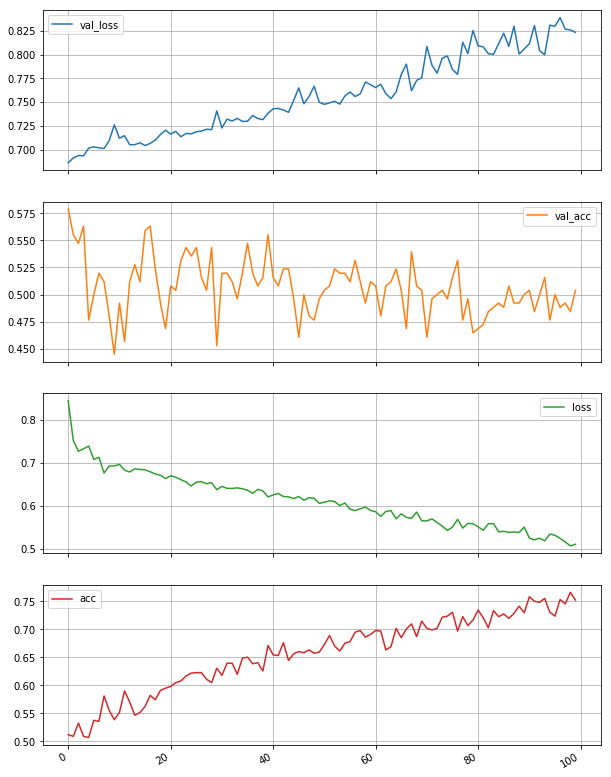

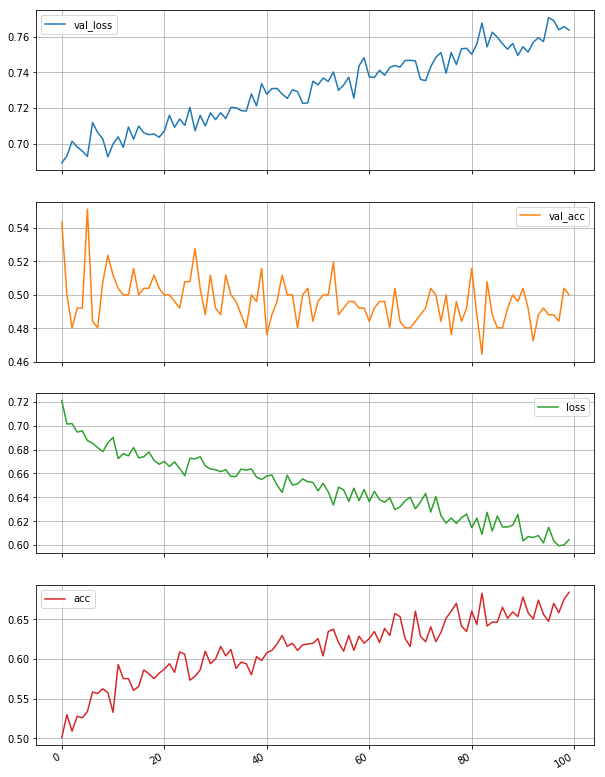

In [58]:
nn_main()